<a href="https://colab.research.google.com/github/Shah-zam9/DVLM_Assignment0/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kqbdm0ux
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-kqbdm0ux
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=13998d97f188098c78de6b85d342708de1cfb5295e5f3fbb9af81f2a068b2b8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ge94lipa/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Using device: cuda


In [2]:
model, preprocess = clip.load("ViT-B/32", device=device)

print("Downloading STL-10...")
stl10_test = STL10(root="./data", split='test', download=True, transform=None)

def get_clip_inputs(dataset, indices=None):
    images = []
    labels = []

    iterable = indices if indices is not None else range(len(dataset))

    for i in iterable:
        img, label = dataset[i]
        images.append(preprocess(img))
        labels.append(label)

    return torch.stack(images).to(device), torch.tensor(labels).to(device)

print("Setup Complete. Model loaded and Dataset ready.")

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.5MiB/s]


100%|██████████| 2.64G/2.64G [00:33<00:00, 77.9MB/s]


Setup Complete. Model loaded and Dataset ready.


In [4]:
import torch
import clip
from torchvision.datasets import STL10
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model, preprocess = clip.load("ViT-B/32", device=device)

print("Loading STL-10 with CLIP preprocessing...")
stl10_test = STL10(root="./data", split='test', download=True, transform=preprocess)
class_names = stl10_test.classes

def strategy_1_plain(label):
    return f"{label}"

def strategy_2_standard(label):
    return f"a photo of a {label}"

def strategy_3_descriptive(label):
    return f"a high resolution photo of a {label} in the stl-10 dataset"

def evaluate_clip_accuracy(dataset, prompt_func, batch_size=32):
    text_inputs = torch.cat([clip.tokenize(prompt_func(c)) for c in class_names]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    correct_count = 0
    total_count = 0

    print(f"Evaluating strategy: '{prompt_func(class_names[0]).replace(class_names[0], '{label}')}'...")

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

            correct_count += (predictions == labels).sum().item()
            total_count += labels.size(0)

    return 100 * correct_count / total_count

acc1 = evaluate_clip_accuracy(stl10_test, strategy_1_plain)
print(f"Strategy 1 (Plain) Accuracy: {acc1:.2f}%")

acc2 = evaluate_clip_accuracy(stl10_test, strategy_2_standard)
print(f"Strategy 2 (Standard) Accuracy: {acc2:.2f}%")

acc3 = evaluate_clip_accuracy(stl10_test, strategy_3_descriptive)
print(f"Strategy 3 (Descriptive) Accuracy: {acc3:.2f}%")

Using device: cuda
Loading STL-10 with CLIP preprocessing...
Evaluating strategy: '{label}'...
Strategy 1 (Plain) Accuracy: 96.26%
Evaluating strategy: 'a photo of a {label}'...
Strategy 2 (Standard) Accuracy: 97.36%
Evaluating strategy: 'a high resolution photo of a {label} in the stl-10 dataset'...
Strategy 3 (Descriptive) Accuracy: 97.01%


Extracting embeddings for 100 samples...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


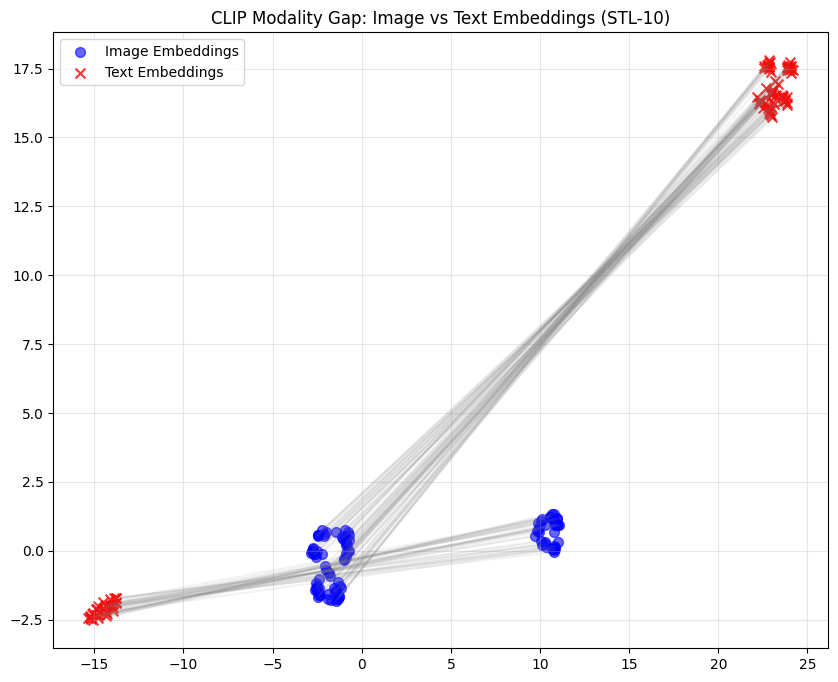

Plot generated. Look for the separation between Red (Text) and Blue (Images).


In [5]:
import umap
import matplotlib.pyplot as plt
import numpy as np

subset_size = 100
indices = np.random.choice(len(stl10_test), subset_size, replace=False)

print(f"Extracting embeddings for {subset_size} samples...")

image_embeddings = []
text_embeddings = []
labels_text = []

with torch.no_grad():
    for i in indices:
        img, label_idx = stl10_test[i]
        label_name = class_names[label_idx]

        img_input = img.unsqueeze(0).to(device)
        img_emb = model.encode_image(img_input)
        img_emb /= img_emb.norm(dim=-1, keepdim=True)

        text_input = clip.tokenize(f"a photo of a {label_name}").to(device)
        text_emb = model.encode_text(text_input)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)

        image_embeddings.append(img_emb.cpu().numpy())
        text_embeddings.append(text_emb.cpu().numpy())
        labels_text.append(label_name)

image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)

combined_embeddings = np.vstack([image_embeddings, text_embeddings])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(combined_embeddings)

img_2d = embedding_2d[:subset_size]
txt_2d = embedding_2d[subset_size:]

plt.figure(figsize=(10, 8))

plt.scatter(img_2d[:, 0], img_2d[:, 1], c='blue', label='Image Embeddings', alpha=0.6, s=50)

plt.scatter(txt_2d[:, 0], txt_2d[:, 1], c='red', marker='x', label='Text Embeddings', alpha=0.8, s=50)

for i in range(subset_size):
    plt.plot([img_2d[i, 0], txt_2d[i, 0]], [img_2d[i, 1], txt_2d[i, 1]],
             color='gray', alpha=0.1)

plt.title("CLIP Modality Gap: Image vs Text Embeddings (STL-10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("modality_gap.png")
plt.show()

print("Plot generated. Look for the separation between Red (Text) and Blue (Images).")

Rotation matrix R calculated.


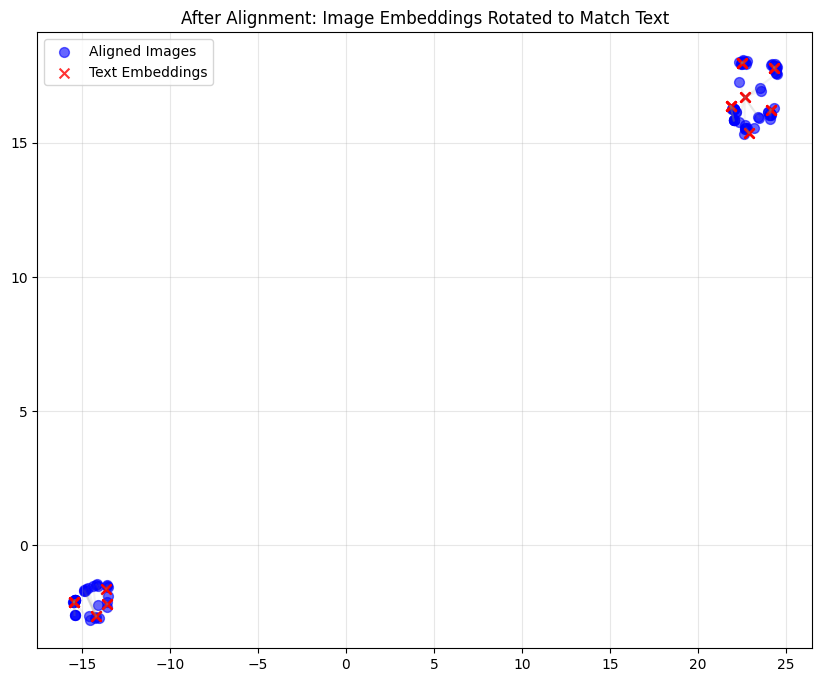

Evaluating accuracy with Aligned Embeddings...
Accuracy BEFORE Alignment: 97.36%
Accuracy AFTER Alignment: 97.11%


In [6]:
from scipy.linalg import orthogonal_procrustes

R, scale = orthogonal_procrustes(image_embeddings, text_embeddings)

print("Rotation matrix R calculated.")

image_embeddings_aligned = image_embeddings @ R

combined_aligned = np.vstack([image_embeddings_aligned, text_embeddings])
embedding_aligned_2d = reducer.transform(combined_aligned)

plt.figure(figsize=(10, 8))
img_aligned_2d = embedding_aligned_2d[:subset_size]
txt_aligned_2d = embedding_aligned_2d[subset_size:]

plt.scatter(img_aligned_2d[:, 0], img_aligned_2d[:, 1], c='blue', label='Aligned Images', alpha=0.6, s=50)
plt.scatter(txt_aligned_2d[:, 0], txt_aligned_2d[:, 1], c='red', marker='x', label='Text Embeddings', alpha=0.8, s=50)

for i in range(subset_size):
    plt.plot([img_aligned_2d[i, 0], txt_aligned_2d[i, 0]],
             [img_aligned_2d[i, 1], txt_aligned_2d[i, 1]],
             color='gray', alpha=0.1)

plt.title("After Alignment: Image Embeddings Rotated to Match Text")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("aligned_gap.png")
plt.show()

def evaluate_aligned_accuracy(dataset, prompt_func, rotation_matrix):
    R_tensor = torch.tensor(rotation_matrix, dtype=torch.float16 if device=='cuda' else torch.float32).to(device)

    text_inputs = torch.cat([clip.tokenize(prompt_func(c)) for c in class_names]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    correct_count = 0
    total_count = 0

    print("Evaluating accuracy with Aligned Embeddings...")

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            image_features = image_features.to(R_tensor.dtype) @ R_tensor

            text_features = text_features.to(R_tensor.dtype)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

            correct_count += (predictions == labels).sum().item()
            total_count += labels.size(0)

    return 100 * correct_count / total_count

acc_aligned = evaluate_aligned_accuracy(stl10_test, strategy_2_standard, R)
print(f"Accuracy BEFORE Alignment: {acc2:.2f}%")
print(f"Accuracy AFTER Alignment: {acc_aligned:.2f}%")